<a href="https://colab.research.google.com/github/rajatdua/dlvr-fgmccb/blob/main/DLVR_Project_FGMCCB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Visual Recognition Project

In this project, We will utilize the Caltech-UCSD Birds 200 (CUB-200-2011) dataset, which comprises a total of 11,788 images depicting 200 distinct bird species. The dataset exhibits a notably **balanced distribution**, with 50 to 60 images available for each individual species. It includes detailed annotations specifying the locations of specific anatomical parts of the birds.

## Fine Grained Multi-Class Classification of Birds (FGMCCB)

Our primary focus will be on employing **EfficientNetB5** for image encoding and implementing a decoder for classification. Due to the inherent similarities among bird features and the challenge of distinguishing them, we will employ the **Triplet Loss**. This loss function encourages the network to minimize the distance between anchor and positive samples while increasing the separation from negative samples within the embedding space. In addition, we will also leverage the **Cross-Entropy Loss**.

### Dataset Classification

#### Source
You can find the source dataset from [here](http://www.vision.caltech.edu/datasets/cub_200_2011/).

#### Details
- Number of categories: 200
- Number of images: 11,788
- Input image dimensions: 224 x 224
- Annotations per image: 15 Part Locations, 312 Binary Attributes, 1 Bounding Box

#### Tech-Stack
- Language: Python
- Framework: PyTorch




#### **Step 1: Data Exploration and Pre-Processing**

1. Mount the google drive and download the dataset
2. Divide the dataset in training, validation and testing datasets

**Note**: Use data augumentation to increase the dataset working space

##### **Step 1.1: Mount the google drive and download the dataset**

###### Environment variables

In [1]:
import os

in_colab = False

if os.getenv("COLAB_RELEASE_TAG"):
   in_colab = True

###### Prerequisite libraries

In [2]:
if not in_colab:
    !pip install google
# common
!pip install tqdm


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


###### Downloading Dataset

In [2]:
import os
import requests
from tqdm import tqdm
import tarfile

# Mount Google Drive
if in_colab:
    from google.colab import drive
    drive.mount('/content/drive')

# Define the dataset URL
dataset_url = "https://data.caltech.edu/records/65de6-vp158/files/CUB_200_2011.tgz?download=1"

# Define the local directory to save the dataset
# local_dir = '/content/dataset'
download_dir = '/content/drive/My Drive/Datasets' if in_colab else './Datasets'

dataset_file = 'CUB_200_2011.tgz'
extracted_folder = 'CUB_200_2011'

in_dir_data = f'{download_dir}/{extracted_folder}'
# Check if the directory already exists
if not os.path.exists(download_dir):
    os.makedirs(download_dir)

# Check if the directory is empty - removed this because it is more robust to check
# if not os.listdir(local_dir):

# Check if the dataset file and folder exist
if not os.path.exists(os.path.join(download_dir, dataset_file)):
    # Download the dataset
    response = requests.get(dataset_url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 KB
    t = tqdm(total=total_size, unit='iB', unit_scale=True)
    with open(os.path.join(download_dir, 'CUB_200_2011.tgz'), 'wb') as file, tqdm(
        desc='Downloading',
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(block_size):
            t.update(len(data))
            bar.update(len(data))
            file.write(data)
    t.close()

if not os.path.exists(os.path.join(download_dir, extracted_folder)):
    # Extract the dataset
    with tarfile.open(os.path.join(download_dir, 'CUB_200_2011.tgz'), 'r:gz') as tar:
        tar.extractall(download_dir)
    print("Dataset downloaded and extracted successfully.")
else:
    print("Dataset already exists in the directory. Skipping download and extraction.")


Dataset already exists in the directory. Skipping download and extraction.


###### Check Dataset Files

In [3]:
import os

# List files in /content/drive/My Drive/Datasets folder
print(f"\nFiles in {download_dir} folder:")
for file in os.listdir(download_dir):
    print(file)

# List files in /content/drive/My Drive/Datasets/CUB_200_2011 folder
print(f"\nFiles in {download_dir}/{extracted_folder} folder:")
for file in os.listdir(f'{download_dir}/{extracted_folder}'):
    print(file)



Files in ./Datasets folder:
.DS_Store
CUB_200_2011.tgz
attributes.txt
CUB_200_2011

Files in ./Datasets/CUB_200_2011 folder:
classes.txt
processed-images
images
map_idx.json
train_test_split.txt
README
attributes
map_parent.json
bounding_boxes.txt
parts
images.txt
image_class_labels.txt


### Step 1.3: Parent and Child Classes

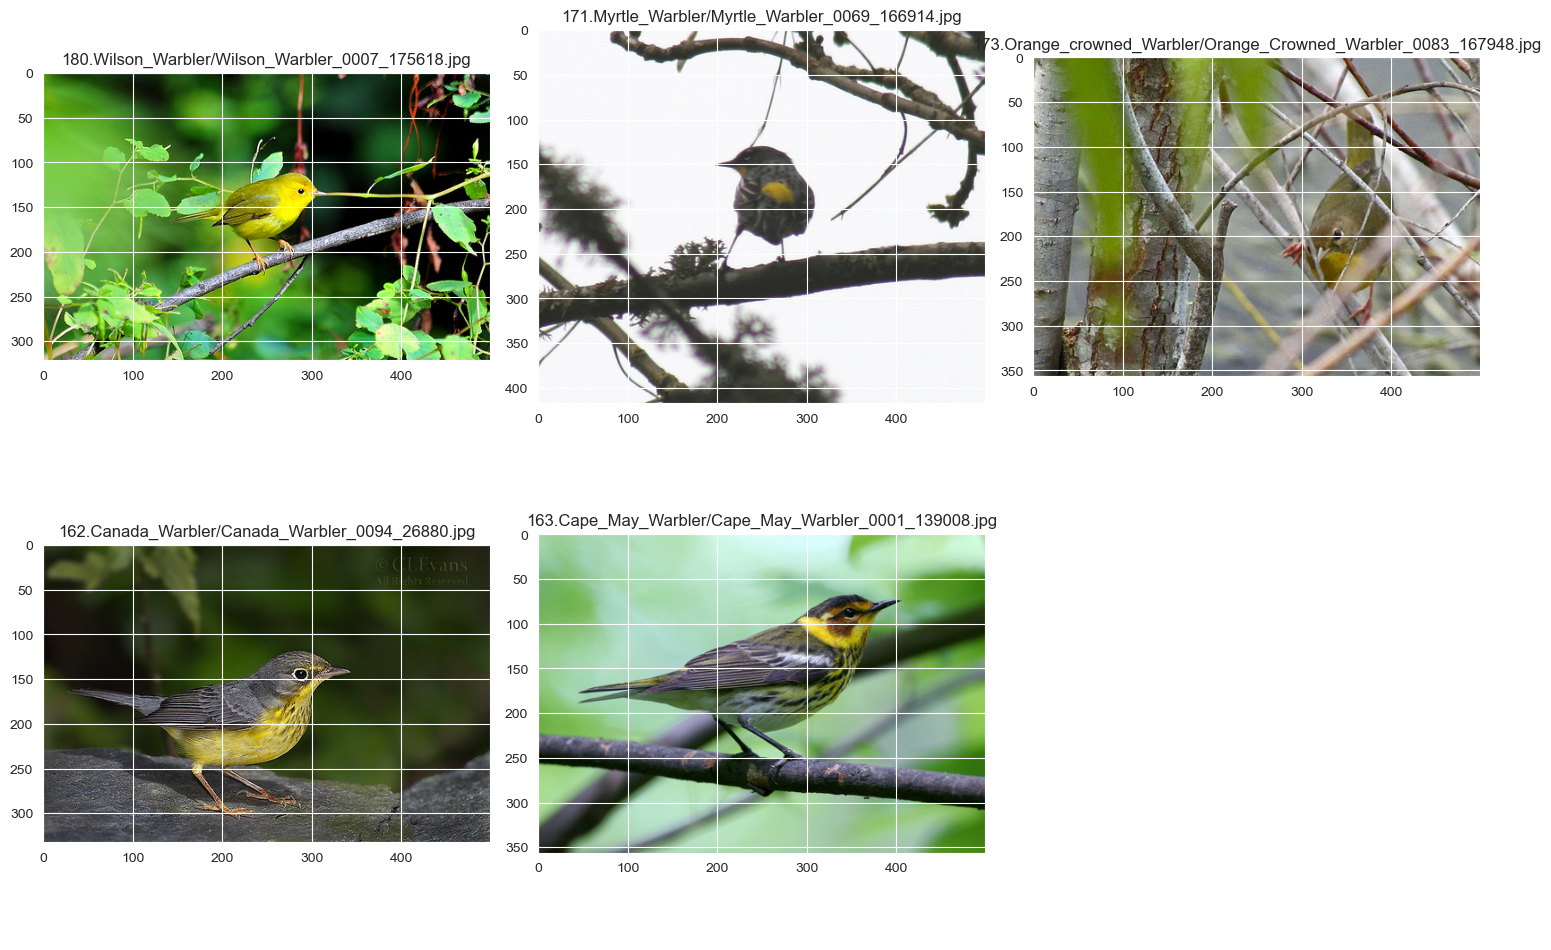

---All Classes (Sorted)---
Parent Key: warbler
Class ID: 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182
Count: 25
Children:
  - bay_breasted
  - black_and_white
  - black_throated_blue
  - blue_winged
  - canada
  - cape_may
  - cerulean
  - chestnut_sided
  - golden_winged
  - hooded
  - kentucky
  - magnolia
  - mourning
  - myrtle
  - nashville
  - orange_crowned
  - palm
  - pine
  - prairie
  - prothonotary
  - swainson
  - tennessee
  - wilson
  - worm_eating
  - yellow

Parent Key: sparrow
Class ID: 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133
Count: 21
Children:
  - baird
  - black_throated
  - brewer
  - chipping
  - clay_colored
  - house
  - field
  - fox
  - grasshopper
  - harris
  - henslow
  - le_conte
  - lincoln
  - nelson_sharp_tailed
  - savannah
  - seaside
  - song
  - tree
  - vesper
  - white_crowned
  - white_throated

Parent Ke

In [4]:
classes_file = f"{download_dir}/CUB_200_2011/classes.txt"
images_file = f"{download_dir}/CUB_200_2011/images.txt"

parent_count = {}

with open(classes_file, 'r') as file:
    for line in file:
        all_details_classes = line.strip().split()
        class_id_and_name = all_details_classes[1]
        class_name = class_id_and_name.split('.')[1].lower()
        classification = class_name.split('_')
        child_class_key = '_'.join(classification[:-1])
        parent_class_key = classification[-1]
        
        if parent_class_key in parent_count:
            parent_count[parent_class_key]['count'] += 1
            parent_count[parent_class_key]['id'].append(all_details_classes[0])
            parent_count[parent_class_key]['child'].append(child_class_key)
        else:
            parent_count[parent_class_key] = {'count': 1, 'child': [child_class_key], 'id': [all_details_classes[0]]}

sorted_parents = sorted(parent_count.items(), key=lambda x: x[1]['count'], reverse=True)


selected_parent_class = sorted_parents[0][0]
selected_child_ids = sorted_parents[0][1]['id']
selected_child_class = sorted_parents[0][1]['child']

import random
combined_array = list(zip(selected_child_ids, selected_child_class))
random_sample = random.sample(combined_array, 5)
resultant_child_id, resultant_child_names = zip(*random_sample)

import re
images_to_show = []

for child_id, child_name in zip(resultant_child_id, resultant_child_names):
    pattern = re.compile(f"{re.escape(child_id)}.{re.escape(child_name)}_{re.escape(selected_parent_class)}", re.IGNORECASE)
    # Open and read the text file
    with open(images_file, "r") as file:
        for line in file:
            if pattern.search(line):
                images_to_show.append(line.strip().split()[1])
                break

import matplotlib.pyplot as plt
import cv2

# Set up the figure and axis
# fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig, axs = plt.subplots(2, 3, figsize=(15, 10))


# Flatten the 2D array of axes
axs = axs.flatten()

# Iterate over image paths and plot each image
for i, image_path in enumerate(images_to_show):
    # Read the image
    img = cv2.imread(os.path.join(download_dir,extracted_folder,'images',image_path))

    # Lab code
    # b,g,r = cv2.split(img)
    # rgb = cv2.merge((r,g,b))
    # plt.imshow(rgb)
    
    # Plot the image
    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    # axs[i].imshow(img, cmap='viridis')

    # Set title with image path
    axs[i].set_title(image_path)

    # Set x and y axis labels
    # axs[i].set_xlabel("X-coordinate")
    # axs[i].set_ylabel("Y-coordinate")

# Remove empty subplots if any
for i in range(len(images_to_show), len(axs)):
    axs[i].axis('off')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()



print('---All Classes (Sorted)---')

for parent_key, data in sorted_parents:
    print(f"Parent Key: {parent_key}")
    print(f"Class ID: {', '.join(data['id'])}")
    print(f"Count: {data['count']}")
    print("Children:")
    for child in data['child']:
        print(f"  - {child}")
    print()

        

### Step 1.4: Average Image Distribution for Best Data Augmentation Strategy

Resizing images: 100%|██████████| 200/200 [00:34<00:00,  5.74it/s]


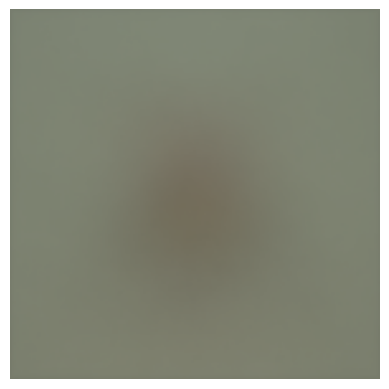

In [5]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

images_path = 'images'

# Set the path to the CUB-200-2011 dataset
dataset_path = f"{download_dir}/{extracted_folder}"

# Function to load and resize images
def load_and_resize_image(file_path, target_size):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    return img

# Get the list of subfolders (bird categories) in the "images" directory
subfolders = [f for f in os.listdir(os.path.join(dataset_path, images_path)) if os.path.isdir(os.path.join(dataset_path, images_path, f))]

# Specify the target size for resizing
target_size = (224, 224)  # You can adjust this based on your requirements

# Initialize an array to store resized images
resized_images = []

# all original image files paths
original_image_files=[]

# Resize and load images from each subfolder
for subfolder in tqdm(subfolders, desc="Resizing images"):
    subfolder_path = os.path.join(dataset_path, images_path, subfolder)
    # Get the list of image files in the subfolder
    image_files = [f for f in os.listdir(subfolder_path) if f.endswith('.jpg')]
    
    # Load and resize images
    for img_file in image_files:
        img_path = os.path.join(subfolder_path, img_file)
        original_image_files.append(img_path)
        resized_img = load_and_resize_image(img_path, target_size)
        resized_images.append(resized_img)

# Stack the images to calculate the average
stacked_images = np.stack(resized_images, axis=0)

# Calculate the average image
average_image = np.mean(stacked_images, axis=0).astype(np.uint8)

# Display the average image
# cv2.imshow("Average Image", cv2.cvtColor(average_image, cv2.COLOR_RGB2BGR))
# cv2.waitKey(0)
# cv2.destroyAllWindows()

plt.imshow(average_image)
plt.axis('off')  # Turn off axis labels
plt.show()


As seen above, the images are center biased. Majority of the bird images are in the middle. We would need to overcome this problem since we need to focus on other parts of the image. 

### Step 1.5: Mean image size for resizing it correct aspect ratio

Mean Width: 468
Mean Height: 386
Max Width: 500
Max Height: 500


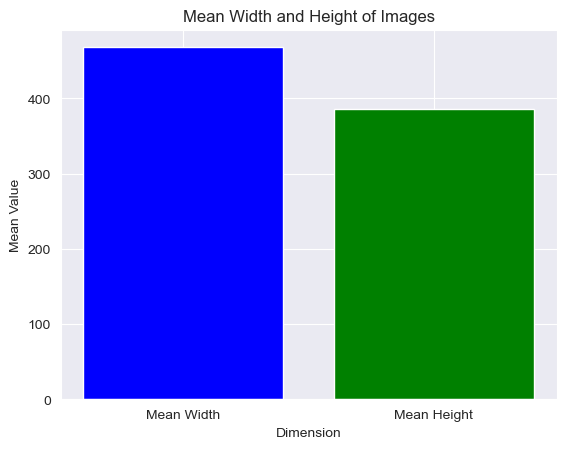

In [6]:
import cv2
import os

def calc_dimensions(image_paths):
    total_width = 0
    total_height = 0
    max_width_1 = 0
    max_height_1 = 0
    num_images = len(image_paths)

    for curr_image_path in image_paths:
        curr_img = cv2.imread(curr_image_path)
        if img is not None:
            curr_height, curr_width, _ = curr_img.shape
            total_width += curr_width
            total_height += curr_height
            max_width_1 = max(max_width_1, curr_width)
            max_height_1 = max(max_height_1, curr_height)

    total_mean_width = round(total_width / num_images)
    total_mean_height = round(total_height / num_images)

    return total_mean_width, total_mean_height, max_width_1, max_height_1

# Example usage
mean_width, mean_height, max_width, max_height = calc_dimensions(original_image_files)

print(f"Mean Width: {mean_width}")
print(f"Mean Height: {mean_height}")
print(f"Max Width: {max_width}")
print(f"Max Height: {max_height}")

# Create a bar chart
labels = ['Mean Width', 'Mean Height']
values = [mean_width, mean_height]

plt.bar(labels, values, color=['blue', 'green'])
plt.xlabel('Dimension')
plt.ylabel('Mean Value')
plt.title('Mean Width and Height of Images')
plt.show()


As you can see that the images are in different widths and height, we will process these images to be in the same aspect ratio however in a bigger size by using zero-padding.

### Step 1.6: Preprocessing dataset to remove background using boundary boxes (Optional)

In [7]:
import cv2
import os
import numpy as np

dataset_path = f"{download_dir}/{extracted_folder}"
subfolders = [f for f in os.listdir(os.path.join(dataset_path, "images")) if os.path.isdir(os.path.join(dataset_path, "images", f))]

images_path = f"{download_dir}/CUB_200_2011/images"
output_dir = f"{download_dir}/CUB_200_2011/processed-images"
boxes_file = f"{download_dir}/CUB_200_2011/bounding_boxes.txt"

os.makedirs(output_dir, exist_ok=True)

boundary_dict = {}
image_dict = {}
image_id_path_dict = {}

with open(images_file, 'r') as file:
    for line in file:
        all_details = line.strip().split()
        image_id = all_details[0]
        image_full_name = all_details[1].split('/')[1]
        image_dict[image_full_name] = image_id
        image_id_path_dict[image_id] = f"{images_path}/{all_details[1]}"

with open(boxes_file, 'r') as file:
    for line in file:
        all_details = line.strip().split()
        boundary_dict[all_details[0]] = {
            'x': int(float(all_details[1])),
            'y': int(float(all_details[2])),
            'width': int(float(all_details[3])),
            'height': int(float(all_details[4])),
        }
        
def capitalize_before_underscore(text):
    words = text.split('_')
    capitalized_words = [word.capitalize() for word in words]
    return '_'.join(capitalized_words)

if not os.path.exists(os.path.join(download_dir, extracted_folder, 'processed-images')):
    # folder = 001.Black_footed_Albatross
    for folder in subfolders:
        folder_details = folder.split('.')
        # had to capitalise it because the folder name and image names are same but not same case
        name_of_bird = capitalize_before_underscore(folder_details[1])
        selected_image_path = os.path.join(images_path, folder)
        # selected_image = Crested_Auklet_0045_794940.jpg (Example)
        for selected_image in os.listdir(selected_image_path):
            full_selected_image_path = os.path.join(selected_image_path, selected_image)
            # <name_of_bird>_<image_number>_<random_number>.jpg; the image_number is extracted by splitting the name of the bird and then splitting it with _
            # image_number = selected_image.split(name_of_bird)[1].split('_')[1]
            image_number = image_dict[selected_image]
            boundary_box_for_image = boundary_dict[f"{int(image_number)}"]
            img = cv2.imread(full_selected_image_path)
            x, y, width, height = boundary_box_for_image["x"], boundary_box_for_image["y"], boundary_box_for_image["width"], boundary_box_for_image["height"]
        
            # Create a binary mask with 1s inside the boundary box and 0s outside
            mask = np.zeros_like(img, dtype=np.uint8)
            mask[y:y+height, x:x+width] = 1
            
            # Apply the mask to the original image
            background = np.ones_like(img) * 255
    
            # Use the mask to combine the original image and the background
            result = img * mask + background * (1 - mask)
    
            # result = img * mask
            # Save the result to the output directory
            new_subfolder_dir = f"{output_dir}/{folder}"
            os.makedirs(new_subfolder_dir, exist_ok=True)
            output_path = os.path.join(output_dir, folder, selected_image)
            cv2.imwrite(output_path, result)
    print("Background removal complete.")
# print(image_id_path_dict)
    

### Step 1.7: Downloading Prerequisite
1. efficientnet_pytorch - Contains all the efficient-net models.
2. torchinfo - Formats the model summary in a viewable manner.
3. matplotlib - For plotting graphs, etc.
4. opencv-python - For random occlusions.
5. seaborn - For generating a heatmap.

In [26]:
!pip install efficientnet_pytorch
if in_colab:
    !pip install torch torchvision --upgrade
else:
    !pip install torch torchvision
!pip install torchinfo
!pip install matplotlib
!pip install opencv-python
!pip install seaborn
!pip install geffnet


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 1.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


### Step 1.8: Imports

In [19]:
import torch
import time
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import TensorDataset
from efficientnet_pytorch import EfficientNet
from torch.utils.data.dataset import random_split
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
import sklearn.model_selection as skms
import seaborn as sns
import matplotlib.pyplot as plt
import torchinfo
import numpy as np
import cv2
import geffnet


# CONSTANTS


def select_device():
    if torch.cuda.is_available():
        print('GPU is available')
        # Check if it's an Apple Silicon GPU
        if 'Metal' in torch.cuda.get_device_properties(0).name:
            selected_device = torch.device('metal')
        else:
            selected_device = torch.device('cuda')
    else:
        if torch.backends.mps.is_available():
            selected_device = torch.device('mps')
            print('GPU is available')
        else:
            selected_device = torch.device('cpu')
            print('GPU is not available')
    
    return selected_device

device = select_device()


GPU is available


### Step 1.9: Generic Data Loader

#### Step 1.9.1: For Data Augmentation

In [11]:
class RandomOcclusion(object):
    def __init__(self, occlusion_prob=0.5, max_occlusion_size=0.2):
        self.occlusion_prob = occlusion_prob
        self.max_occlusion_size = max_occlusion_size

    def __call__(self, image):
        if np.random.rand() < self.occlusion_prob:
            h, w, _ = image.shape
            occlusion_mask = np.ones((h, w, 3), dtype=np.uint8)
            occlusion_size = int(self.max_occlusion_size * min(h, w))

            # Randomly select the position of the occlusion
            top = np.random.randint(0, h - occlusion_size)
            left = np.random.randint(0, w - occlusion_size)

            # Apply occlusion (e.g., black rectangle)
            occlusion_mask[top:top + occlusion_size, left:left + occlusion_size, :] = 0
            image = cv2.add(image, occlusion_mask)

        return image

#### Step 1.10: Data Distribution

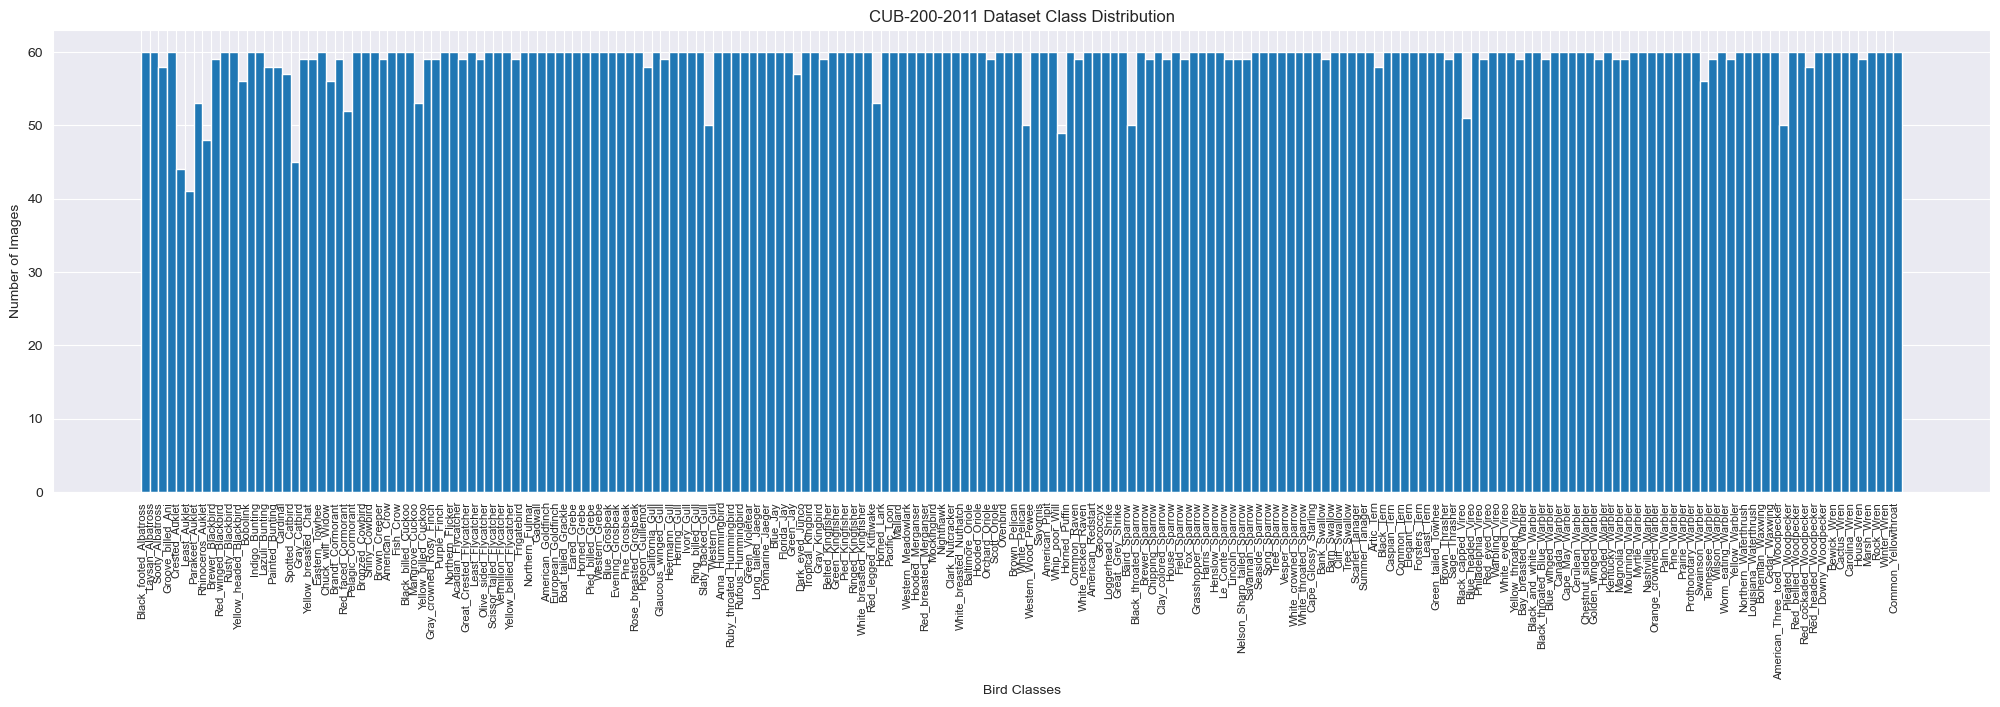

In [34]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import random


image_folder = 'images'

# Create a DataFrame to store class distribution
class_distribution = []

for class_folder in sorted(os.listdir(os.path.join(download_dir, extracted_folder, image_folder))):
    class_path = os.path.join(f'{download_dir}/{extracted_folder}', image_folder, class_folder)
    num_images = len(os.listdir(class_path))
    class_distribution.append({'class': class_folder, 'num_images': num_images})
    # Add empty categories
    # class_distribution.append({'class': f'.{random.randint(100, 999)}', 'num_images': 0})

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(class_distribution)

# Extract the part after the dot in the 'class' column
df['class'] = df['class'].apply(lambda x: x.split('.')[1])

# df['class'] = df['class'].apply(lambda x: '' if x.split('.')[1].isdigit() else x.split('.')[1])

# Plotting the distribution
plt.figure(figsize=(25, 6))
plt.bar(df['class'], df['num_images'], width=1, align='edge')
plt.xlabel('Bird Classes')
plt.ylabel('Number of Images')
plt.title('CUB-200-2011 Dataset Class Distribution')
plt.xticks(rotation=90, fontsize=8)
plt.show()


#### **Step 2: Basic EfficientB0 Baseline**

#### Step 2.1: Baseline Model

In [12]:

# input_size = (456, 456)
# Original
input_size = (224, 224)

# Load the dataset
dataset_path = '/content/drive/MyDrive/Datasets/CUB_200_2011/images/' if in_colab else './Datasets/CUB_200_2011/processed-images/' 
# Change above processed-images to images for original images with bg

# without data augmentation
transform_bl = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

# with data augmentation
# transform = transforms.Compose([
#     transforms.RandomResizedCrop(input_size),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(15),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

#with occlusion and data augmentation
#transform = transforms.Compose([
#    RandomOcclusion(occlusion_prob=0.5, max_occlusion_size=0.2),
#    transforms.RandomResizedCrop(input_size),
#    transforms.RandomHorizontalFlip(),
#    transforms.RandomVerticalFlip(),
#    transforms.RandomRotation(15),
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#])

# possible color adjustments to be added (after RandomRotation beforeToTensor)
#    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust image color
#    transforms.RandomGrayscale(p=0.1),  # Randomly apply grayscale
#    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),  # Apply perspective transformation

print('Preparing dataset')
dataset = datasets.ImageFolder(dataset_path, transform=transform_bl)

print('Splitting dataset')
# Split the dataset into training and validation sets
train_size = int(0.6 * len(dataset))
val_size = int((len(dataset) - train_size)/2)
test_size = int((len(dataset) - train_size)/2)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
# test_dataset 60% 20% 20%
# test_dataset 80% 10% 10%

# Occlusion added - masking
# Occlusion needs to be updated for the annotations / attributes (parts of bird)

print('Loader setup')
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2) #shuffle - should the data be randomly shuffled during each epoch of training
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Load the pre-trained model

print(f"Device: {device}")

# Used in saving the model as well
model_type = 'b0'

num_classes = 200

def set_baseline_model():
    my_model = EfficientNet.from_pretrained(f'efficientnet-{model_type}')
    for my_param in my_model.parameters():
        my_param.requires_grad = False

    # Unfreeze the last few layers (adjust as needed)
    for my_param in my_model._conv_head.parameters():
        my_param.requires_grad = True
    for my_param in my_model._bn1.parameters():
        my_param.requires_grad = True
    for my_param in my_model._fc.parameters():
        my_param.requires_grad = True
    my_model._fc = nn.Linear(my_model._fc.in_features, num_classes)
    return my_model

model = set_baseline_model()

# Print the model summary
print(torchinfo.summary(model))

# Loss function, optimizer and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)


# Early stopping parameters
patience = 10
early_stopping_counter = 0
best_loss = None

# Training loop
train_losses = []
val_losses = []

max_epoch = 1

all_predictions = []
all_labels = []

# Moved it down, because the model was in different device
model = model.to(device)

for epoch in range(max_epoch):  # Adjust as needed
    print(f'Starting Epoch: {epoch + 1}')
    train_loss = 0.0
    val_loss = 0.0

    # Training phase
    model.train()
    print(f'Size: {len(train_dataloader.dataset)}')
    start_time = time.time()
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    end_time = time.time()
    #scheduler.step()

    execution_time = end_time - start_time
    print(f'Training {epoch + 1} took {execution_time} s')

    # Validation phase
    start_time_v = time.time()
    correct = 0
    total = 0
    top1_correct = 0
    top5_correct = 0
    model.eval()
    for inputs, labels in val_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Calculate top-1 error
        top1_correct += predicted.eq(labels).sum().item()

        # Calculate top-5 error
        _, top5_predicted = outputs.topk(5, dim=1)
        top5_correct += top5_predicted.eq(labels.view(-1, 1)).sum().item()

        # Store predictions and labels
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    end_time_v = time.time()

    execution_time_v = end_time_v - start_time_v
    print(f'Validating {epoch + 1} took {execution_time_v} s')

    # Calculate average losses
    train_loss = train_loss / len(train_dataloader.dataset)
    val_loss = val_loss / len(val_dataloader.dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch: {epoch + 1}, Training Loss: {train_loss}, Validation Loss: {val_loss}')
    print(f'Accuracy: {100 * correct / total}%')

    # Compute and print Precision, Recall and F1-score
    # By using 'macro'-averaging, calculate metrics for each label and find their mean (instead of 'micro'-averaging which calculates metrics globally)
    # Warning: Be cautious with label imbalances
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1_score = 2 * precision * recall / (precision + recall)

    print(f"Precision={precision}, Recall={recall}, F1-Score={f1_score}")

    # Calculate top-1 error percentage
    top1_error = 100 * (1 - top1_correct / total)
    # Calculate top-5 error percentage
    top5_error = 100 * (1 - top5_correct / total)

    print(f'Top-1 Error: {top1_error}%')
    print(f'Top-5 Error: {top5_error}%')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    ax = plt.subplot()
    sns.set(font_scale=0.5) # Adjust to fit
    sns.heatmap(conf_matrix, annot=False, ax=ax, cmap="Blues", fmt="g");  

    # Labels, title and ticks for confusion matrix
    label_font = {'size':'2'}
    ax.set_xlabel('Predicted labels', fontdict=label_font);
    ax.set_ylabel('Observed labels', fontdict=label_font);

    title_font = {'size':'15'}
    ax.set_title('Confusion Matrix', fontdict=title_font);
    plt.show()

    # Check for early stopping - Maybe check PyTorch in-build early stopping mechanism
    if best_loss is None or val_loss < best_loss:
        best_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print('Early stopping triggered')
        break
    print(f'Ending Epoch: {epoch + 1}')

# Plotting the training and validation losses
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

# Convert lists to NumPy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Print or visualize the results
for i in range(len(all_predictions)):
    print(f"Sample {i + 1}: Predicted={all_predictions[i]}, Actual={all_labels[i]}")


Preparing dataset
Splitting dataset
Loader setup
Device: mps
Loaded pretrained weights for efficientnet-b0
Layer (type:depth-idx)                             Param #
EfficientNet                                       --
├─Conv2dStaticSamePadding: 1-1                     864
│    └─ZeroPad2d: 2-1                              --
├─BatchNorm2d: 1-2                                 (64)
├─ModuleList: 1-3                                  --
│    └─MBConvBlock: 2-2                            --
│    │    └─Conv2dStaticSamePadding: 3-1           (288)
│    │    └─BatchNorm2d: 3-2                       (64)
│    │    └─Conv2dStaticSamePadding: 3-3           (264)
│    │    └─Conv2dStaticSamePadding: 3-4           (288)
│    │    └─Conv2dStaticSamePadding: 3-5           (512)
│    │    └─BatchNorm2d: 3-6                       (32)
│    │    └─MemoryEfficientSwish: 3-7              --
│    └─MBConvBlock: 2-3                            --
│    │    └─Conv2dStaticSamePadding: 3-8           (1,536)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x153d3b490>
Traceback (most recent call last):
  File "/Users/rajat/anaconda3/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/Users/rajat/anaconda3/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/rajat/anaconda3/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Users/rajat/anaconda3/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/Users/rajat/anaconda3/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/Users/rajat/anaconda3/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


KeyboardInterrupt: 

#### Step 2.2: Save Model

In [9]:
def get_trained_model_path():
    return '/content/drive/MyDrive/TrainedModels' if in_colab else './TrainedModels'

In [19]:
# saving the trained baseline ENB{model_type} model
import time

trained_model_path = get_trained_model_path()

last_trained_model = int(time.time())

def generate_save_path(selected_model_type, replacer_value):
    common_save_path = f'{trained_model_path}/baseline_en{selected_model_type}_model_{last_trained_model}{replacer_value}.pth'
    return common_save_path

model_save_path_dict = generate_save_path(model_type, '_dict')

import os

if not os.path.exists(model_save_path_dict):
  os.makedirs(os.path.dirname(model_save_path_dict), exist_ok=True)

torch.save(model.state_dict(), model_save_path_dict)
print(f"Trained model saved at {model_save_path_dict}")

model_save_path = generate_save_path(model_type, '')

torch.save(model, model_save_path)
print(f"Trained model saved at {model_save_path}")

Trained model saved at ./TrainedModels/baseline_enb0_model_1701097164_dict.pth
Trained model saved at ./TrainedModels/baseline_enb0_model_1701097164.pth


#### Step 2.3: Load from Model

In [ ]:
# Load the model from saved directory
if in_colab:
    from google.colab import drive
    drive.mount('/content/drive')

# Set the path to the saved model
model_load_path_dict = f'{trained_model_path}/baseline_en{model_type}_model_{last_trained_model}_dict.pth'

model = set_baseline_model()

# Load the state dictionary into the model
model.load_state_dict(torch.load(model_load_path_dict))

# Set the model to evaluation mode (important if using layers like dropout)
model.eval()


#### Step 2.4: Calculate Precision and Recall

In [ ]:
# Compute and print Precision and Recall
from sklearn.metrics import precision_score, recall_score

# By using 'macro'-averaging, calculate metrics for each label and find their mean (instead of 'micro'-averaging which calculates metrics globally)
# Warning: Be cautious with label imbalances
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')

print(f"Precision={precision}, Recall={recall}")

#### Step 2.5: Plot Confusion Matrix

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
ax = plt.subplot()

sns.set(font_scale=0.5) # Adjust to fit
sns.heatmap(conf_matrix, annot=False, ax=ax, cmap="Blues", fmt="g");  

# Labels, title and ticks for confusion matrix
label_font = {'size':'2'}
ax.set_xlabel('Predicted labels', fontdict=label_font)
ax.set_ylabel('Observed labels', fontdict=label_font)

title_font = {'size':'15'}
ax.set_title('Confusion Matrix', fontdict=title_font)
plt.show()

# cm = confusion_matrix(all_labels, all_predictions)

# # Print the confusion matrix
# print("Confusion Matrix:")
# print(cm)

# plt.figure(figsize=(12, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

### Step 3: Our Model - Data Augmentation + Multi Task (Boundary Boxes) + Triplet Loss (Custom Anchors)

#### **Step 3.1: Prepare dictionaries for boundary_boxes, part_names and part_locations**

In [10]:
import numpy as np

# Load bounding box data
num_parts = 0
bounding_boxes = {}
part_names = {}
part_locations = {}

path_for_preprocess = f'{download_dir}/{extracted_folder}'

with open(f'{path_for_preprocess}/bounding_boxes.txt', 'r') as f:
    for line in f:
        parts = line.strip().split()
        image_id, x, y, width, height = parts
        bounding_boxes[image_id] = {'x': int(float(x)), 'y': int(float(y)), 'width': int(float(width)), 'height': int(float(height))}
        
with open(f'{path_for_preprocess}/parts/parts.txt', 'r') as f:
    for line in f:
        part_id, part_name = line.strip().split(' ', 1)
        part_names[part_id] = part_name
        num_parts += 1

with open(f'{path_for_preprocess}/parts/part_locs.txt', 'r') as f:
    for line in f:
        parts = line.strip().split()
        image_id, part_id, x, y, visible = parts
        if image_id not in part_locations:
            part_locations[image_id] = {}
        part_locations[image_id][part_id] = {'x': int(float(x)), 'y': int(float(y)), 'visible': bool(visible)}
        

#### **Step 3.1.1: Setup Transformers and DataLoaders**

#### **Step 3.2: Train our Model - Iteration 1 (Only Data Augmentation)**

In [22]:
import os
import torch
import sys

if in_colab:
    py_file_location = "/content/drive/My Drive/Scripts"
    sys.path.append(os.path.abspath(py_file_location))

from torchvision import datasets, transforms
from importlib import reload
import bird_dataset
reload(bird_dataset)

from bird_dataset import BirdsDataset
import torchvision as tv
# import torchvision.transforms.functional as TF
from utils import max_padding

# transform images
transforms_train = tv.transforms.Compose([
   max_padding, # aspect ratio correct with 375x500
   tv.transforms.RandomOrder([
       # tv.transforms.Resize((224, 224)),
       tv.transforms.RandomCrop((375, 375)),
       tv.transforms.RandomHorizontalFlip(),
       tv.transforms.RandomVerticalFlip()
   ]),
   tv.transforms.ToTensor(),
   tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transforms_eval = tv.transforms.Compose([
   max_padding,
   # tv.transforms.Resize((224, 224)),
   tv.transforms.CenterCrop((375, 375)),
   tv.transforms.ToTensor(),
   tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

ds_train = BirdsDataset(in_dir_data, transform=transforms_train, train=True, use_bounding_boxes=True, use_triplet=True)
ds_val = BirdsDataset(in_dir_data, transform=transforms_eval, train=True, use_bounding_boxes=True, use_triplet=True)
ds_test = BirdsDataset(in_dir_data, transform=transforms_eval, train=False, use_bounding_boxes=True, use_triplet=True)

RANDOM_SEED = 42

splits = skms.StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=RANDOM_SEED)
idx_train, idx_val = next(splits.split(np.zeros(len(ds_train)), ds_train.targets))

# set hyper-parameters
params = {'batch_size': 8, 'num_workers': 2}
num_epochs = 100
num_classes = 200

# instantiate data loaders
train_loader = DataLoader(
   dataset=ds_train,
   sampler=SubsetRandomSampler(idx_train),
   **params
)
val_loader = DataLoader(
   dataset=ds_val,
   sampler=SubsetRandomSampler(idx_val),
   **params
)
test_loader = DataLoader(dataset=ds_test, **params)

# from torchvision.models.efficientnet import MBConvConfig

# class MBConvConfig:
#     def __init__(self, input_channels, output_channels, expand_ratio, num_layers, stride):
#         self.input_channels = input_channels
#         self.output_channels = output_channels
#         self.expand_ratio = expand_ratio
#         self.num_layers = num_layers
#         self.stride = stride

# inverted_residual_setting = [
#     MBConvConfig(16, 16, 1, 1, 1),
#     MBConvConfig(16, 24, 6, 2, 2),
#     MBConvConfig(24, 40, 6, 2, 2),
#     MBConvConfig(40, 80, 6, 3, 2),
#     MBConvConfig(80, 112, 6, 3, 2),
#     MBConvConfig(112, 192, 6, 4, 2),
#     MBConvConfig(192, 320, 6, 1, 1),
# ]

# inverted_residual_setting = [s.__dict__ for s in inverted_residual_setting]

# model = tv.models.EfficientNet(num_classes=num_classes, dropout=0.3, inverted_residual_setting=inverted_residual_setting).to(device=device)
model_type = 'b0'
model = EfficientNet.from_pretrained(f'efficientnet-{model_type}')
for my_param in model.parameters():
    my_param.requires_grad = False

# Unfreeze the last few layers (adjust as needed)
for my_param in model._conv_head.parameters():
    my_param.requires_grad = True
for my_param in model._bn1.parameters():
    my_param.requires_grad = True
for my_param in model._fc.parameters():
    my_param.requires_grad = True
model._fc = nn.Linear(model._fc.in_features, num_classes)

# Loading the model
# model = geffnet.create_model('efficientnet_b0', pretrained=True)

# Freezing all the layers
# for param in model.parameters():
#   param.requires_grad = False
  
# Changing the Classifier
# model.classifier = nn.Sequential(nn.Linear(1280,512),
#                            nn.ReLU(),
#                            nn.Dropout(p=0.4),
#                            nn.Linear(512,128),
#                            nn.ReLU(),
#                            nn.Dropout(p=0.4),
#                            nn.Linear(128,200))

# Making the Classifier layer Trainable                           
# for param in model.classifier.parameters():
#   param.requires_grad = True
  
  
model = model.to(device)

# instantiate optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
# print(model)

# from torch.cuda.amp import autocast, GradScaler
# scaler = GradScaler()
# torch.backends.metal.enabled = True

# for param in model.parameters():
#     print(param.dtype)
snapshot_out_dir = get_trained_model_path()
best_snapshot_path = None

if __name__ == '__main__':
    val_acc_avg = list()
    best_val_acc = -1.0
    cls_pred_list = []
    cls_true_list = []
    
    for epoch in range(num_epochs):
        print(f'Starting Epoch: #{epoch + 1}')
        correct = 0
        total = 0
        # train the model
        model.train()
        train_loss = list()
        for batch in train_loader:
            x, y, t = batch
            
            anchor, positive_anchor, negative_anchor = t[0]
            
            reference = anchor.to(device)
            positive = positive_anchor.to(device)
            negative = negative_anchor.to(device)
            
            x = x.to(device)
            y = y.to(device)
    
            # x = x.to(device=device, dtype=torch.float32)
            # y = y.to(device=device, dtype=torch.float32)
            
            optimizer.zero_grad()
            
            y_pred = model(x)
            reference_out = model(reference)
            positive_out = model(positive)
            negative_out = model(negative)
            
            # predict bird species
            y_pred_cls = y_pred[..., :-4]
            y_cls = y[..., 0].long()
        
            # predict bounding box coordinates
            y_pred_bbox = y_pred[..., -4:]
            y_bbox = y[..., 1:]
    
            # calculate the loss
            loss_cls = nn.functional.cross_entropy(y_pred_cls, y_cls)
            loss_bbox = nn.functional.mse_loss(torch.sigmoid(y_pred_bbox), y_bbox)
            triplet_loss = nn.TripletMarginLoss(margin=0.5)(reference_out, positive_out, negative_out)

            loss = loss_cls + loss_bbox + triplet_loss
            
            # backprop & update weights 
            loss.backward()
            optimizer.step()
            # scaler.scale(loss).backward()
            # scaler.step(optimizer)
            # scaler.update()
    
            train_loss.append(loss.item())
            
        # validate the model
        model.eval()
        val_loss = list()
        val_acc = list()
        top1_list = list()
        top5_list = list()
        top1_correct = 0
        top5_correct = 0
        with torch.no_grad():
            for batch in val_loader:
                x, y, t = batch
                
                x = x.to(device)
                y = y.to(device)
                
                anchor, positive_anchor, negative_anchor = t[0]
            
                reference = anchor.to(device)
                positive = positive_anchor.to(device)
                negative = negative_anchor.to(device)
            
             
                y_pred = model(x) # change the output of a layer to return 20
                reference_out = model(reference)
                positive_out = model(positive)
                negative_out = model(negative)
    
                # predict bird species
                y_pred_cls = y_pred[..., :-4]
                y_cls = y[..., 0].long()
                # predict bounding box coordinates
                y_pred_bbox = y_pred[..., -4:]
                y_bbox = y[..., 1:]
                
                # TODO: just use t.
                
                # calculate the loss
                loss_cls = nn.functional.cross_entropy(y_pred_cls, y_cls)
                loss_bbox = nn.functional.mse_loss(torch.sigmoid(y_pred_bbox), y_bbox)
                triplet_loss = nn.TripletMarginLoss(margin=0.5)(reference_out, positive_out, negative_out)

                
                # TODO: once the indexes are out, calc the loss as well
                loss = loss_cls + loss_bbox + triplet_loss
                
                # Flatten the tensors if needed
                # y_flat = y.view(-1).cpu().numpy()
                # y_pred_flat = y_pred.cpu().numpy()

                y_pred_cls_discrete = y_pred_cls.argmax(dim=1).cpu().numpy()
                cls_pred_list.extend(y_pred_cls_discrete)
                
                cls_true_list.extend(y_cls.cpu().numpy())
                
                # Calculate accuracy
                # acc = accuracy_score(y_flat, y_pred_flat)
                
                # y_true = []
                # y_pred_acc = []
                # 
                # for row, pred_row in zip(y, y_pred.argmax(dim=-1)):
                #     for val in row:
                #         y_true.append(val.item())
                #     y_pred_acc.append(pred_row.item())

                # for row in y:
                #     for val in row:
                #         y_true.append(val.item())
                # 
                # for row in y_pred.argmax(dim=-1):
                #     print(f'y_pred row: {row}')
                #     y_pred_acc.append(row.item())
                    # for val in row:
                    #     y_pred_acc.append(val.item())
                
                
                # get the index of the max log-probability
                pred = y_pred_cls.argmax(dim=1, keepdim=True)
                correct += pred.eq(y_cls.view_as(pred)).sum().item()
                total += y_cls.size(0)
                
                pred_top5 = y_pred_cls.topk(5, dim=1)[1]
                pred_top1 = pred_top5[:, :1]
                
                top1_correct += pred_top1.eq(y_cls.view_as(pred_top1)).sum().item()
                correct_top5 = pred_top5.eq(y_cls.view(-1, 1).expand_as(pred_top5))
                # top5_correct += pred_top5.eq(y_cls.view_as(pred_top5)).sum().item()
                # top5_correct = pred_top5.eq(y_cls.view(-1, 1).expand_as(pred_top5))
                
                top5_correct += correct_top5.sum().item()
                
                top1_acc = top1_correct / total
                top5_acc = top5_correct / total
                # top5_acc = top5_correct / total
                
                top1_list.append(top1_acc)
                top5_list.append(top5_acc)
                
                # y_true = [val.item() for val in y]
                # y_pred_acc = [val.item() for val in y_pred.argmax(dim=-1)]
                # print(f'y_true: {y_true}')
                # print(f'y_true len: {len(y_true)}')
                # print(f'y_pred_acc: {y_pred_acc}')
                # print(f'y_pred_acc len: {len(y_pred_acc)}')
                # # calculate the accuracy
                # acc = accuracy_score(y_true, y_pred_acc)
                # val_acc.append(acc)
                val_loss.append(loss.item())
                
            acc = correct / total
            val_acc.append(acc)
            
            val_acc_avg.append(np.mean(val_acc))
            
            # save the best model snapshot
            current_val_acc = val_acc_avg[-1]
            if current_val_acc > best_val_acc:
                if best_snapshot_path is not None:
                    os.remove(best_snapshot_path)

                best_val_acc = current_val_acc
                best_snapshot_path = os.path.join(snapshot_out_dir, f'model_multi_data_aug_ep={epoch}_acc={best_val_acc}.pt')

                torch.save(model.state_dict(), best_snapshot_path)
        
        # adjust the learning rate
        scheduler.step()
    
        # print performance metrics
        # if (epoch == 0) or ((epoch + 1) % 10 == 0):
        print('Epoch {} |> Train. loss: {:.4f} | Val. loss: {:.4f}'.format(
            epoch + 1, np.mean(train_loss), np.mean(val_loss))
        )
         # Print or store the accuracies as needed
        print(f'Top-1 Accuracy: {top1_acc * 100:.2f}%')
        print(f'Top-5 Accuracy: {top5_acc * 100:.2f}%')
    # use the best model snapshot
    # model.load_state_dict(torch.load(best_snapshot_path, map_location=device))
    
    cls_pred = np.array(cls_pred_list)
    cls_true = np.array(cls_true_list)
    precision = precision_score(cls_true, cls_pred, average='macro', zero_division=1)
    recall = recall_score(cls_true, cls_pred, average='macro')
    f1 = f1_score(cls_true, cls_pred, average='macro')
    
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    
    # test the model
    true = list()
    pred = list()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader:
            x, y, _ = batch
    
            x = x.to(device)
            y = y.to(device)
    
            y_pred = model(x)
            
            y = y[..., 0]
            y_pred = y_pred[..., :-4]
    
            # true.extend([val.item() for val in y])
            # pred.extend([val.item() for val in y_pred.argmax(dim=-1)])
            # get the index of the max log-probability
            pred = y_pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()
            total += y.size(0)
    
    # calculate and save the accuracy
    test_accuracy = correct / total
    # test_accuracy = accuracy_score(true, pred)
    # log_accuracy(path_to_logs, model_desc, test_accuracy)
    
    print('Test accuracy: {:.3f}'.format(test_accuracy))

Loaded pretrained weights for efficientnet-b0
Starting Epoch: #1
Epoch 1 |> Train. loss: 6.3018 | Val. loss: 5.2952
Top-1 Accuracy: 34.83%
Top-5 Accuracy: 62.67%
Starting Epoch: #2
Epoch 2 |> Train. loss: 4.6487 | Val. loss: 4.4661
Top-1 Accuracy: 46.67%
Top-5 Accuracy: 74.67%
Starting Epoch: #3
Epoch 3 |> Train. loss: 3.9139 | Val. loss: 4.0782
Top-1 Accuracy: 54.83%
Top-5 Accuracy: 79.17%
Starting Epoch: #4
Epoch 4 |> Train. loss: 3.4047 | Val. loss: 4.2718
Top-1 Accuracy: 56.50%
Top-5 Accuracy: 79.50%
Starting Epoch: #5
Epoch 5 |> Train. loss: 3.1123 | Val. loss: 4.1356
Top-1 Accuracy: 57.83%
Top-5 Accuracy: 83.00%
Starting Epoch: #6
Epoch 6 |> Train. loss: 2.7815 | Val. loss: 4.2441
Top-1 Accuracy: 62.50%
Top-5 Accuracy: 83.67%
Starting Epoch: #7
Epoch 7 |> Train. loss: 2.5864 | Val. loss: 4.2642
Top-1 Accuracy: 62.17%
Top-5 Accuracy: 85.00%
Starting Epoch: #8
Epoch 8 |> Train. loss: 2.3812 | Val. loss: 3.9467
Top-1 Accuracy: 62.33%
Top-5 Accuracy: 85.83%
Starting Epoch: #9
Epoch 9

In [26]:
mean_training_loss = [6.3018,
4.6487,
3.9139,
3.4047,
3.1123,
2.7815,
2.5864,
2.3812,
2.1976,
2.0613,
1.9104,
1.7857,
1.6394,
1.5754,
1.5171,
1.4410,
1.3181,
1.3027,
1.2374,
1.1493,
1.0796,
1.0451,
1.0309,
0.9909,
0.9144,
0.9001,
0.8605,
0.8459,
0.8272,
0.7940,
0.7656,
0.7700,
0.6833,
0.7109,
0.6725,
0.6146,
0.6236,
0.6735,
0.6094,
0.5957,
0.5571,
0.6085,
0.5430,
0.5528,
0.5527,
0.5202,
0.5592,
0.4958,
0.4914,
0.4745,
0.4861,
0.5025,
0.4730,
0.4619,
0.4768,
0.4519,
0.4707,
0.4458,
0.4390,
0.4492,
0.4311,
0.4316,
0.4397,
0.4275,
0.4107,
0.4215,
0.4119,
0.4138,
0.4144,
0.4137,
0.4025,
0.4074,
0.4378,
0.4277,
0.4138,
0.4005,
0.4057,
0.4536,
0.3600,
0.3976,
0.3825,
0.3718,
0.4161,
0.3826,
0.3906,
0.3620,
0.3803,
0.3881,
0.3776,
0.3621,
0.3705,
0.3712,
0.3747,
0.3691,
0.3718,
0.3710,
0.3621,
0.3650,
0.4025,
0.3539]


mean_validation_loss = [5.2952,
4.4661,
4.0782,
4.2718,
4.1356,
4.2441,
4.2642,
3.9467,
4.1770,
4.2298,
4.0505,
4.0758,
4.1138,
4.0256,
4.1180,
4.1454,
3.9672,
3.9253,
3.8969,
3.8844,
3.7145,
3.7989,
3.6484,
3.7063,
3.5961,
3.6479,
3.6049,
3.6251,
3.5710,
3.6271,
3.5686,
3.6044,
3.6314,
3.5689,
3.4817,
3.5895,
3.6374,
3.5225,
3.5464,
3.6113,
3.5388,
3.5649,
3.5574,
3.5243,
3.5425,
3.5269,
3.5000,
3.4993,
3.4901,
3.5186,
3.4621,
3.4426,
3.4572,
3.4592,
3.5151,
3.5125,
3.4917,
3.5183,
3.5170,
3.4924,
3.4898,
3.4875,
3.4726,
3.4554,
3.4864,
3.4721,
3.4482,
3.4222,
3.4375,
3.4765,
3.4409,
3.4270,
3.4197,
3.3989,
3.4572,
3.4259,
3.4229,
3.3935,
3.4470,
3.4005,
3.4149,
3.4527,
3.4088,
3.4168,
3.4098,
3.4005,
3.4181,
3.4229,
3.3999,
3.4314,
3.4192,
3.4107,
3.4201,
3.3919,
3.3974,
3.4175,
3.4038,
3.3986,
3.3849,
3.4216]

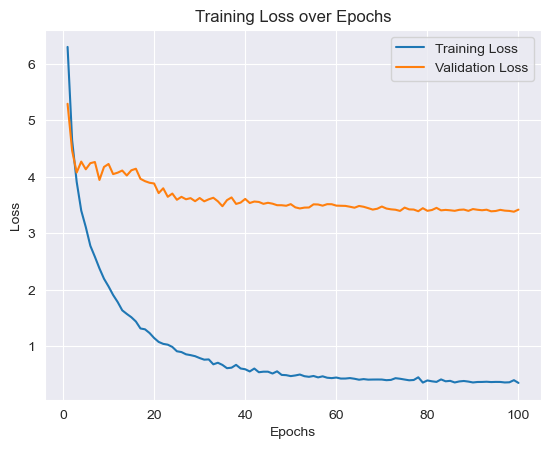

In [28]:
import matplotlib.pyplot as plt
import numpy as np


# Generate x-axis values (epochs)
epochs = range(1, len(mean_training_loss) + 1)

# Plotting the training loss
plt.plot(epochs, mean_training_loss, label='Training Loss')
plt.plot(epochs, mean_validation_loss, label='Validation Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [23]:
print(val_acc_avg)

[0.34833333333333333, 0.4666666666666667, 0.5483333333333333, 0.565, 0.5783333333333334, 0.625, 0.6216666666666667, 0.6233333333333333, 0.6483333333333333, 0.6316666666666667, 0.615, 0.6433333333333333, 0.6416666666666667, 0.65, 0.6883333333333334, 0.6866666666666666, 0.6866666666666666, 0.6766666666666666, 0.6933333333333334, 0.7066666666666667, 0.69, 0.69, 0.69, 0.7116666666666667, 0.7216666666666667, 0.71, 0.7, 0.7066666666666667, 0.7, 0.7033333333333334, 0.7233333333333334, 0.7133333333333334, 0.71, 0.7083333333333334, 0.7133333333333334, 0.7133333333333334, 0.705, 0.7133333333333334, 0.7216666666666667, 0.7316666666666667, 0.7383333333333333, 0.7283333333333334, 0.7283333333333334, 0.7366666666666667, 0.725, 0.725, 0.7283333333333334, 0.7283333333333334, 0.7283333333333334, 0.7383333333333333, 0.735, 0.7333333333333333, 0.7366666666666667, 0.7333333333333333, 0.7366666666666667, 0.7316666666666667, 0.7366666666666667, 0.7333333333333333, 0.7333333333333333, 0.74, 0.751666666666666

In [24]:
print(train_loss)

[0.4560835659503937, 0.5446925759315491, 0.0433971993625164, 0.1773035079240799, 0.055142857134342194, 0.03432421013712883, 0.40630432963371277, 0.6774207949638367, 0.6185322999954224, 0.03770986199378967, 0.05913391709327698, 0.2638128995895386, 0.08143654465675354, 0.09831186383962631, 0.646944522857666, 0.6312664747238159, 0.12091707438230515, 0.3854371905326843, 0.15605999529361725, 0.16751833260059357, 0.09235559403896332, 0.5258616209030151, 0.11585962772369385, 0.057523176074028015, 0.29726311564445496, 0.19992201030254364, 0.11720413714647293, 1.0602947473526, 0.06223566085100174, 0.3305504322052002, 0.6628590822219849, 0.26503250002861023, 0.7292192578315735, 0.7273334264755249, 0.06689316779375076, 0.28528937697410583, 0.05737186223268509, 1.5560637712478638, 0.06948500126600266, 0.15034331381320953, 0.1361854523420334, 1.1302450895309448, 0.258413702249527, 0.5966798067092896, 0.28225529193878174, 0.9557114839553833, 0.15735752880573273, 0.04800282046198845, 0.06015133485198

In [25]:
print(val_loss)

[2.772348642349243, 0.5494832992553711, 1.070531964302063, 1.0899202823638916, 5.137234687805176, 2.5779786109924316, 3.464233875274658, 1.242242693901062, 1.053634762763977, 4.500362396240234, 3.200076103210449, 3.9963574409484863, 2.7576420307159424, 3.994734764099121, 4.043731212615967, 5.063542366027832, 0.37281808257102966, 0.6310073733329773, 2.121894359588623, 0.1784941554069519, 1.0989612340927124, 6.49206018447876, 5.813742637634277, 5.127209663391113, 1.8194717168807983, 10.48996353149414, 3.076951503753662, 7.329041481018066, 4.80037260055542, 0.7987803816795349, 2.4819235801696777, 2.9117023944854736, 5.495675563812256, 5.607305526733398, 6.085730075836182, 2.140255928039551, 6.451587200164795, 2.382350444793701, 2.5204901695251465, 4.614415645599365, 2.2176804542541504, 6.063549041748047, 2.201021194458008, 4.125551223754883, 2.2842724323272705, 6.748700141906738, 2.723297357559204, 2.746821403503418, 1.7813584804534912, 0.9492702484130859, 1.824674367904663, 2.47018146514

In [26]:
print(val_acc)

[0.7366666666666667]


In [27]:
print(cls_pred_list)

[99, 18, 95, 164, 72, 130, 69, 152, 113, 78, 145, 67, 0, 35, 166, 20, 118, 110, 4, 145, 181, 44, 53, 89, 25, 169, 76, 38, 76, 98, 145, 147, 138, 113, 150, 50, 158, 86, 88, 138, 0, 147, 130, 130, 190, 194, 56, 72, 161, 181, 150, 29, 46, 108, 145, 73, 131, 32, 25, 14, 166, 158, 7, 56, 73, 40, 166, 62, 96, 145, 135, 146, 44, 147, 127, 145, 145, 82, 62, 28, 169, 91, 20, 50, 130, 101, 152, 97, 89, 46, 38, 46, 54, 191, 108, 78, 130, 169, 162, 13, 142, 56, 166, 62, 102, 102, 130, 17, 132, 0, 4, 170, 159, 80, 128, 25, 187, 128, 130, 79, 190, 166, 46, 82, 145, 108, 3, 102, 118, 158, 145, 138, 25, 162, 145, 72, 190, 127, 138, 47, 113, 35, 38, 109, 62, 162, 165, 92, 192, 158, 130, 167, 144, 92, 101, 52, 187, 110, 99, 131, 7, 103, 144, 138, 68, 67, 17, 164, 29, 144, 194, 158, 188, 150, 169, 79, 39, 38, 138, 84, 118, 60, 46, 128, 128, 169, 67, 118, 138, 88, 40, 145, 170, 145, 89, 138, 145, 164, 145, 56, 89, 51, 138, 103, 120, 20, 184, 4, 145, 158, 92, 43, 20, 73, 164, 67, 189, 130, 46, 5, 150, 123,

In [28]:
print(cls_true_list)

[99, 8, 97, 164, 73, 173, 69, 151, 113, 78, 198, 68, 0, 35, 117, 117, 118, 141, 107, 146, 181, 2, 53, 89, 25, 171, 37, 177, 73, 162, 140, 147, 55, 113, 142, 49, 182, 86, 88, 43, 44, 42, 130, 148, 190, 87, 75, 72, 161, 181, 165, 28, 54, 135, 143, 104, 131, 185, 9, 14, 167, 163, 45, 56, 152, 136, 94, 77, 96, 142, 135, 146, 134, 147, 127, 145, 58, 82, 62, 107, 199, 91, 20, 50, 126, 39, 36, 97, 50, 180, 154, 46, 54, 191, 108, 77, 122, 76, 175, 13, 83, 56, 167, 62, 90, 192, 149, 17, 132, 0, 24, 38, 159, 80, 198, 13, 187, 173, 103, 81, 190, 180, 176, 82, 143, 108, 3, 102, 36, 158, 145, 138, 10, 155, 142, 72, 190, 90, 41, 47, 93, 35, 114, 193, 58, 124, 165, 92, 196, 158, 182, 167, 145, 92, 102, 52, 187, 110, 99, 132, 57, 119, 140, 188, 197, 68, 85, 55, 28, 144, 194, 170, 30, 111, 168, 79, 77, 36, 10, 132, 116, 60, 11, 148, 130, 166, 22, 116, 138, 45, 40, 140, 115, 144, 89, 15, 141, 153, 59, 56, 89, 51, 138, 148, 197, 20, 185, 102, 63, 192, 18, 43, 25, 165, 194, 67, 189, 149, 179, 5, 31, 123, 

#### **Step 3.3: Train our Model - Iteration 1 (Only Triplet Loss)**

#### **Step 3.4: Train our Model - Iteration 1 (Only Multi-Task)**

#### **Step 3.5: Train our Model - Iteration 2 (Data Augmentation + Multi-Task)**

#### **Step 3.6: Train our Model - Iteration 2 (Data Augmentation + Multi-Task + Triplet Loss)**

### **Step 4 Compare Custom CNN vs Baseline**

### **Step 5: Benchmarking - F-Score**

# Appendix

##### **Step 1.2: Divide the dataset in training, validation and testing datasets**

In [ ]:
# not needed at the moment
!pip install split-folders

In [ ]:
# not needed at the moment
import splitfolders

input = '/content/drive/MyDrive/Datasets/CUB_200_2011/images'
output ='/content/drive/MyDrive/Datasets/CUB_200_2011_divided'


# Set a tuple as "ratio" to split the dataset into training, validation and test set
# Other ratios to consider: .7, .15, .15 or .6, .2, .2
splitfolders.ratio(input, output=output, seed=42, ratio=(.8, .1, .1), group_prefix=None)


## Baseline Version 1

In [ ]:
# Version 1

import torch

torch.hub._download_url_to_file = lambda url, filename, **kwargs: (filename, True)

import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import StepLR

# Define constants
input_size = (456, 456)  # EfficientNetB5 input size
num_classes = 200  # Number of bird species in CUB-200-2011

from efficientnet_pytorch import EfficientNet

should_freeze_layer = False

# Create a basic EfficientNetB5 model
class EfficientNetB5Model(nn.Module):
    def __init__(self, num_classes, freeze_layers=True):
        super(EfficientNetB5Model, self).__init__()
        self.base_model = EfficientNet.from_pretrained('efficientnet-b5', num_classes=num_classes)
        if freeze_layers:
          for param in self.base_model.parameters():
              param.requires_grad = False

    def forward(self, x):
        return self.base_model(x)


# Create a basic EfficientNetB5 model - EFB5 from torchvision
# class EfficientNetB5Model(nn.Module):
#     def __init__(self, num_classes):
#         super(EfficientNetB5Model, self).__init__()
#         self.base_model = models.efficientnet_b5(pretrained=True)
#         in_features = self.base_model._fc.in_features
#         self.base_model._fc = nn.Linear(in_features, num_classes)

#     def forward(self, x):
#         return self.base_model(x)

# Instantiate the model
model = EfficientNetB5Model(num_classes, freeze_layers=should_freeze_layer)

# Set device (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

torch.cuda.empty_cache()

# Print the model summary
print(model)


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Implement gradient clipping to limit the magnitude of gradients during training. This can help prevent exploding gradients and save memory.
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

# Modify the data loading part
transform_bl1 = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Specify the path to the dataset
dataset_path = '/content/drive/MyDrive/Datasets/CUB_200_2011/images/'

# Create the dataset
dataset = ImageFolder(root=dataset_path, transform=transform_bl1)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader instances for training and validation sets
# Changed batch size from 32 to 16 to 8 - it worked with 8 (12.4 GB GPU), failed with 32 & 16 because of out of memory
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

accumulation_steps = 2  # Accumulate gradients for every two batches

# Lists to store training and validation losses -- ADDED LATER (NEED TO RETRAIN)
train_losses = []
val_losses = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    print(f'Start of epoch: #{epoch + 1}')
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        # optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
         # Backward pass only for parameters that require gradients
        # if any(param.requires_grad for param in model.parameters()):
        #     loss.backward()
        #     optimizer.step()
        #     optimizer.zero_grad()
        # loss.backward() - Put inside if statement because freeze_layer True for some layers doesn't calculate the gradient
        # Accumulate gradients
        # if (i + 1) % accumulation_steps == 0:
        #     optimizer.step()
        #     optimizer.zero_grad()

        running_loss += loss.item()

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    # ADDED LATER - NEED TO RETRAIN
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    # Print statistics
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {val_loss / len(val_loader)}, Accuracy: {100 * correct / total}%")

# Plot training and validation loss curves - ADDED LATER (NEED TO RETRAIN)
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

print(f'End of epoch: #{epoch + 1}')
